In [1]:
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers

2023-07-23 11:49:20.235616: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-23 11:49:21.394840: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/student1/openssl/lib:
2023-07-23 11:49:21.394946: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/student1/openssl/lib:
2023-07-23 11:49:21.394960: W tensorflow/compiler/tf2tensorrt/utils/py_uti

In [2]:
batch_size = 100
img_height = 250
img_width = 250

In [3]:
training_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'data/train',
    seed=101,
    image_size=(img_height, img_width),
    batch_size=batch_size

)

testing_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'data/test',
    seed=101,
    image_size=(img_height, img_width),
    batch_size=batch_size)

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'data/val',
    seed=101,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 791 files belonging to 2 classes.
Found 100 files belonging to 2 classes.
Found 98 files belonging to 2 classes.


2023-07-23 11:50:27.093720: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-23 11:50:27.817204: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10405 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:89:00.0, compute capability: 6.1


In [4]:
class_names = training_ds.class_names

## Configuring dataset for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
training_ds = training_ds.cache().prefetch(buffer_size=AUTOTUNE)
testing_ds = testing_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [5]:
import tensorflow as tf
from tensorflow.keras import layers
import keras_spiking

img_shape = (img_height, img_width, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=img_shape,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

# Input data does not need a time dimension for this approach
inp = tf.keras.Input(img_shape)

# Add SpikingActivation to Conv2D layers
model = tf.keras.Sequential([
    base_model,
    layers.Conv2D(32, 3),
    keras_spiking.SpikingActivation('relu',dt = 0.1),
    layers.Conv2D(64, 3),
    keras_spiking.SpikingActivation('relu'),
    layers.Conv2D(128, 3),
    keras_spiking.SpikingActivation('relu'),

    layers.Flatten(),
    layers.Dense(len(class_names), activation= 'softmax')
])

spiking_model = tf.keras.Model(inp, model(inp))

spiking_model.summary()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 2)                 2720034   
                                                                 
Total params: 2,720,034
Trainable params: 462,050
Non-trainable params: 2,257,984
_________________________________________________________________


In [6]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [7]:
history = model.fit(training_ds, validation_data = validation_ds, epochs = 100)

Epoch 1/100


2023-07-23 11:50:39.240184: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8200
2023-07-23 11:50:40.920392: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f82644200b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-23 11:50:40.920466: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2023-07-23 11:50:40.934301: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-23 11:50:41.353535: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


8/8 [==============================] - 12s 427ms/step - loss: 68.0105 - accuracy: 0.4893 - val_loss: 73.0375 - val_accuracy: 0.5204
Epoch 2/100
8/8 [==============================] - 1s 150ms/step - loss: 88.4536 - accuracy: 0.5107 - val_loss: 102.8635 - val_accuracy: 0.4490
Epoch 3/100
8/8 [==============================] - 1s 151ms/step - loss: 93.4866 - accuracy: 0.5272 - val_loss: 115.8167 - val_accuracy: 0.5204
Epoch 4/100
8/8 [==============================] - 1s 149ms/step - loss: 108.6657 - accuracy: 0.5297 - val_loss: 95.5113 - val_accuracy: 0.5714
Epoch 5/100
8/8 [==============================] - 1s 150ms/step - loss: 119.6809 - accuracy: 0.4968 - val_loss: 124.8097 - val_accuracy: 0.6020
Epoch 6/100
8/8 [==============================] - 1s 151ms/step - loss: 114.0116 - accuracy: 0.5487 - val_loss: 135.1213 - val_accuracy: 0.5102
Epoch 7/100
8/8 [==============================] - 1s 150ms/step - loss: 109.6387 - accuracy: 0.5689 - val_loss: 85.4530 - val_accuracy: 0.6429
Ep

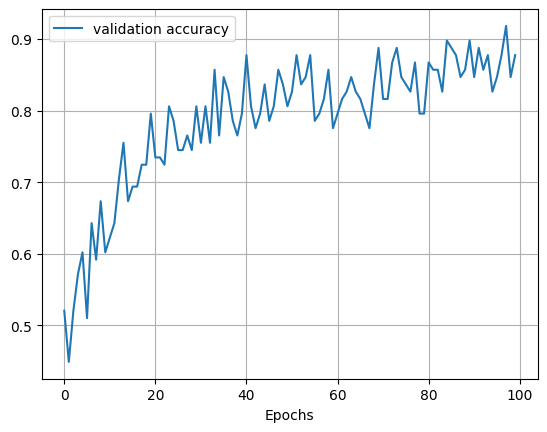

In [10]:
# plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
#epochs
plt.xlabel('Epochs')
plt.title('Validation Accuracy SNN')
plt.grid(True)
plt.legend()

In [9]:
# final accuracy on test set
model.evaluate(testing_ds)

1/1 [==============================] - 0s 241ms/step - loss: 7.2096 - accuracy: 0.8400


[7.209586143493652, 0.8399999737739563]